In [84]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from sequencing_tools.viz_tools import color_encoder
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})

In [70]:
with open('/stor/work/Lambowitz/cdw2854/miRNA/ercc/weight.pkl', 'rb') as index:
    weights = pickle.load(index)

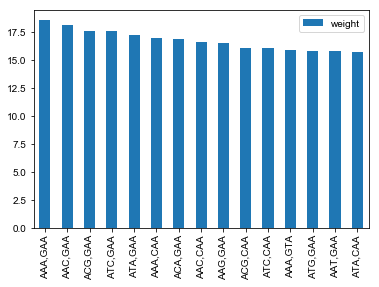

In [71]:
pd.DataFrame().from_dict(weights, orient='index', columns=['weight']) \
    .nlargest(15, 'weight')\
    .plot.bar()

In [72]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/mir_count.feather')
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,mir,MTT1_corrected,MTT1_filter,MTT2_corrected,MTT2_filter,MTT3_corrected,MTT3_filter,NTC1_corrected,NTC1_filter,NTC2_corrected,...,NTT3_corrected,NTT3_filter,NTT6N_corrected,NTT6N_filter,NTTR1_corrected,NTTR1_filter,NTTR2_corrected,NTTR2_filter,NTTR3_corrected,NTTR3_filter
0,EBV-1-1,480.484999,6287.0,504.320955,11303.0,550.909158,12095.0,288.231209,5890.0,169.532884,...,267.576013,5639.0,257.078809,5057.0,1424.424699,22060.0,1025.424174,20639.0,2520.514763,46991.0
1,EBV-1-2,5334.375850,305147.0,6384.205324,369161.0,7037.846078,396818.0,7502.694319,449568.0,7164.884498,...,10174.543667,592579.0,6285.707165,386929.0,5714.730298,284681.0,4374.065288,254675.0,5089.448822,310512.0
2,EBV-1-2-star,662.832977,19552.0,1086.531618,26014.0,1544.005770,36634.0,228.112987,7892.0,305.554771,...,1148.545614,32420.0,1005.908357,31148.0,861.746060,23114.0,873.866329,26926.0,1257.581071,37018.0
3,EBV-1-3,567.676085,26851.0,903.191084,45919.0,933.446113,47389.0,948.840044,54692.0,1148.402576,...,1012.729205,60603.0,669.125661,40682.0,273.707183,14350.0,421.084173,23321.0,541.804602,25983.0
4,EBV-1-3P,2509.490276,81595.0,3203.850147,96361.0,3762.145746,125180.0,1709.309959,51143.0,1199.688312,...,1966.627432,60635.0,2421.193477,84659.0,11638.899681,385841.0,8651.353811,293981.0,6874.072045,206803.0


In [85]:
ce = color_encoder()
mir_df = df\
    .set_index('mir')\
    .transform(lambda x: x/x.sum() * 1e6)\
    .pipe(pd.melt, value_name = 'mir_count', var_name = 'sn')\
    .assign(correct = lambda d: np.where(d['sn'].str.contains('corrected'), 'Corrected', 'Uncorrected'))\
    .assign(color = lambda d: ce.fit_transform(d.correct))
mir_df.head()

,sn,mir_count,correct,color
0,MTT1_corrected,94.807589,Corrected,#56B4E9
1,MTT1_corrected,1052.560047,Corrected,#56B4E9
2,MTT1_corrected,130.787843,Corrected,#56B4E9
3,MTT1_corrected,112.011824,Corrected,#56B4E9
4,MTT1_corrected,495.163685,Corrected,#56B4E9


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


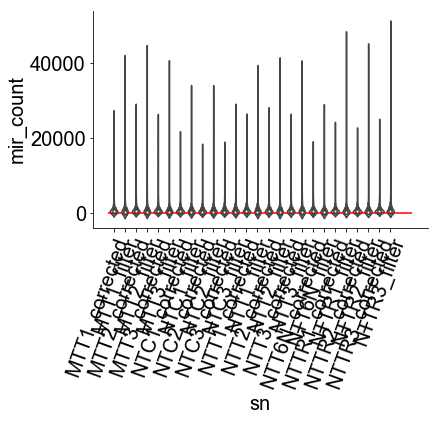

In [86]:
ax = plt.subplot(111)
sns.violinplot(data=mir_df, x = 'sn', y ='mir_count')
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=70,
                        rotation_mode='anchor', ha ='right')
ax.hlines(xmin = -0.5, xmax = len(mir_df.sn.unique())+1, 
         y = np.log(1e6/962), color = 'red')
sns.despine()

In [87]:
rmse = mir_df \
    .assign(error = lambda d: d.mir_count - 1e6/962)\
    .groupby(['sn','correct','color'], as_index=False)\
    .agg({'error': lambda e: np.sqrt(np.sum(e**2)) })\
    .assign(log_e = lambda d: np.log(d.error))\
    .sort_values('log_e')
rmse.head()

,sn,correct,color,error,log_e
24,NTTR3_corrected,Corrected,#56B4E9,46602.913546,10.749418
22,NTTR2_corrected,Corrected,#56B4E9,52562.121470,10.869751
4,MTT3_corrected,Corrected,#56B4E9,54111.719189,10.898806
20,NTTR1_corrected,Corrected,#56B4E9,55337.204848,10.921201
2,MTT2_corrected,Corrected,#56B4E9,56813.379628,10.947527


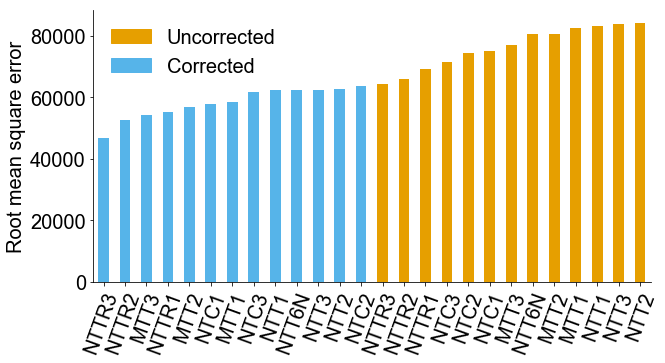

In [93]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
rmse.plot.bar('sn', 'error', color = rmse.color, ax = ax)
sns.despine()
ax.legend().set_visible(False)
xts = []
for xt in ax.get_xticklabels():
    xts.append(xt.get_text().split('_')[0])
ax.set_xticklabels(xts, rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_xlabel('')
ax.set_ylabel('Root mean square error')
ce.show_legend(ax, title='', fontsize=20, frameon=False)
fig.savefig('')